In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("🔄 Loading FD001 data...")
# Column names: unit, cycle, 3 settings, 21 sensors
col_names = ['unit', 'cycle'] + [f'setting{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]

# Load train_FD001.txt
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep='\s+', header=None, names=col_names)
print(f"✅ Loaded: {train_df.shape}")


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\MOUNIKA\AppData\Local\Temp\ipykernel_13952\2107167353.py:10: SyntaxWarning: invalid escape sequence '\s'
  train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep='\s+', header=None, names=col_names)


🔄 Loading FD001 data...
✅ Loaded: (20631, 26)


In [3]:
# Calculate RUL = max_cycle_per_unit - current_cycle
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']
train_df = train_df.merge(max_cycles, on='unit')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

print("✅ RUL calculated")
print("Sample RUL per unit:")
print(train_df.groupby('unit')['RUL'].first().head())


✅ RUL calculated
Sample RUL per unit:
unit
1    191
2    286
3    178
4    188
5    268
Name: RUL, dtype: int64


In [4]:
# Normalize 21 sensors only (settings stay unscaled)
scaler = MinMaxScaler()
sensor_cols = [f'sensor{i}' for i in range(1,22)]
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])

print("✅ Sensors normalized (0-1)")
print(f"Sensor 1 range: {train_df['sensor1'].min():.3f} to {train_df['sensor1'].max():.3f}")


✅ Sensors normalized (0-1)
Sensor 1 range: 0.000 to 0.000


In [5]:
def create_sequences(df, seq_length=30):
    X, y = [], []
    sensor_cols = [f'sensor{i}' for i in range(1,22)]
    
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].reset_index(drop=True)
        for i in range(seq_length, len(unit_df)):
            X.append(unit_df[sensor_cols].iloc[i-seq_length:i].values)
            y.append(unit_df['RUL'].iloc[i])
    return np.array(X), np.array(y)

print("🔄 Creating sequences...")
X_fd001, y_fd001 = create_sequences(train_df)
print(f"✅ Sequences: X({X_fd001.shape}), y({y_fd001.shape})")


🔄 Creating sequences...
✅ Sequences: X((17631, 30, 21)), y((17631,))


In [6]:
# Save ALL artifacts
np.savez_compressed('fd001_sequences.npz', X=X_fd001, y=y_fd001)
np.save('fd001_scaler.npy', scaler)
train_df.to_csv('fd001_preprocessed.csv', index=False)

print("🎉 MILESTONE 1 COMPLETE!")
print("✅ Files saved:")
print("   fd001_sequences.npz")
print("   fd001_scaler.npy")
print("   fd001_preprocessed.csv")


🎉 MILESTONE 1 COMPLETE!
✅ Files saved:
   fd001_sequences.npz
   fd001_scaler.npy
   fd001_preprocessed.csv


In [7]:
from sklearn.model_selection import train_test_split

# Split data: 60% train, 20% val, 20% test
X_temp, X_val, y_temp, y_val = train_test_split(X_fd001, y_fd001, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"✅ Splits created:")
print(f"   Train: X({X_train.shape}), y({y_train.shape})")
print(f"   Val:   X({X_val.shape}), y({y_val.shape})")
print(f"   Test:  X({X_test.shape}), y({y_test.shape})")


✅ Splits created:
   Train: X((7052, 30, 21)), y((7052,))
   Val:   X((3527, 30, 21)), y((3527,))
   Test:  X((7052, 30, 21)), y((7052,))


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_gru_model():
    model = Sequential([
        tf.keras.layers.Input(shape=(30, 21)),
        GRU(50, return_sequences=True),
        Dropout(0.2),
        GRU(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model = build_gru_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 50)         │        10,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,551 (107.62 KB)

 Trainable params: 27,551 (107.62 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

print("✅ Training COMPLETE!")




Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 6271.9155 - val_loss: 3743.5906
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 3887.9385 - val_loss: 3733.7524
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 3228.7244 - val_loss: 1456.5876
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1315.7554 - val_loss: 1034.2903
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1163.7571 - val_loss: 1099.2759
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1130.7142 - val_loss: 1044.6217
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1088.3850 - val_loss: 968.0791
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1088.4725 - val_loss: 1062.7734
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1041.2028 - val_loss: 997.0643
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1015.5492 - val_loss: 954.6100
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1009.8203

In [10]:
# Quick validation check
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(np.mean((y_val_pred.flatten() - y_val)**2))
print(f"✅ Validation RMSE: {val_rmse:.2f}")


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
✅ Validation RMSE: 30.29


In [12]:
# FIXED: Save weights with .weights.h5 extension
model.save_weights('fd001_gru_model.weights.h5')

# Save splits (unchanged)
np.savez_compressed('fd001_splits.npz', X_train=X_train, X_val=X_val, X_test=X_test,
                   y_train=y_train, y_val=y_val, y_test=y_test)

print("🎉 STEP 2 COMPLETE!")
print("✅ Files saved:")
print("   fd001_gru_model.weights.h5")
print("   fd001_splits.npz")


🎉 STEP 2 COMPLETE!
✅ Files saved:
   fd001_gru_model.weights.h5
   fd001_splits.npz


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Test predictions
y_test_pred = model.predict(X_test).flatten()
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = np.mean(np.abs(y_test - y_test_pred))

print(f"✅ Test RMSE: {test_rmse:.2f}")
print(f"✅ Test MAE: {test_mae:.2f}")


221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
✅ Test RMSE: 30.19
✅ Test MAE: 19.40


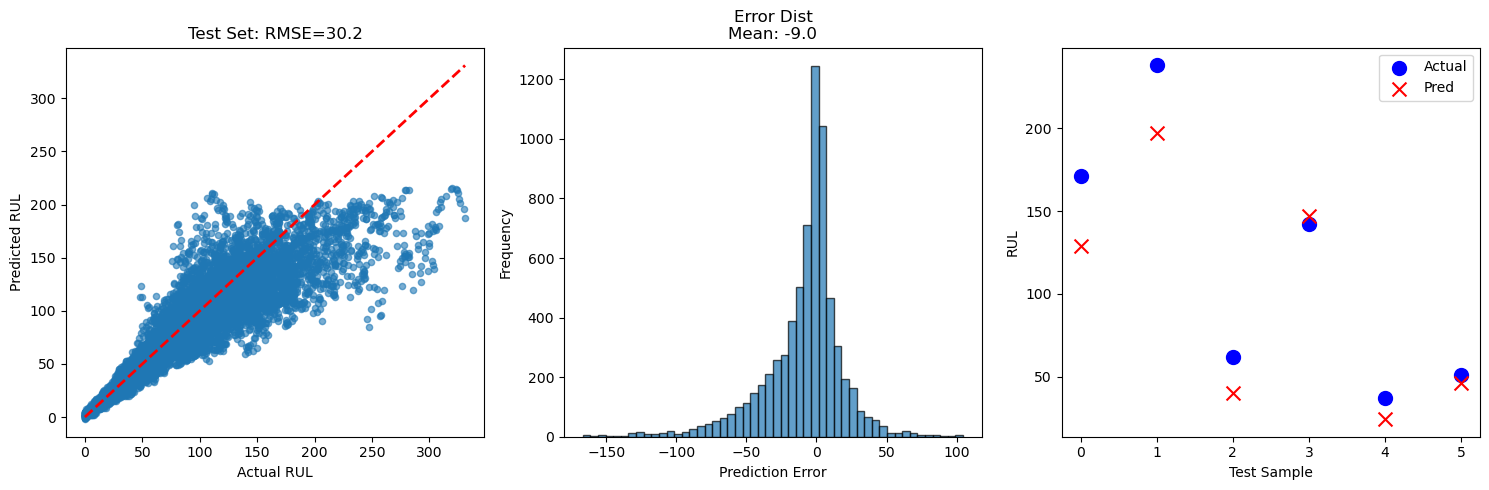

In [14]:
plt.figure(figsize=(15, 5))

# Plot 1: Predicted vs Actual RUL
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL'); plt.ylabel('Predicted RUL')
plt.title(f'Test Set: RMSE={test_rmse:.1f}')

# Plot 2: Error Distribution
plt.subplot(1, 3, 2)
errors = y_test_pred - y_test
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error'); plt.ylabel('Frequency')
plt.title(f'Error Dist\nMean: {errors.mean():.1f}')

# Plot 3: Sample Predictions
plt.subplot(1, 3, 3)
for i in range(0, 30, 5):
    plt.scatter(i//5, y_test[i], c='blue', s=100, label='Actual' if i==0 else "")
    plt.scatter(i//5, y_test_pred[i], c='red', marker='x', s=100, label='Pred' if i==0 else "")
plt.xlabel('Test Sample'); plt.ylabel('RUL')
plt.legend()

plt.tight_layout()
plt.savefig('fd001_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# Save for dashboard
np.savez('fd001_evaluation.npz', y_test=y_test, y_test_pred=y_test_pred, 
         rmse=test_rmse, mae=test_mae)

print("🎉 STEP 3 COMPLETE!")
print("✅ Files saved:")
print("   fd001_evaluation.npz")
print("   fd001_evaluation_plots.png")


🎉 STEP 3 COMPLETE!
✅ Files saved:
   fd001_evaluation.npz
   fd001_evaluation_plots.png


In [16]:
# Alert thresholds
def classify_alert(rul):
    if rul < 10: return 'CRITICAL'
    elif rul < 30: return 'WARNING'
    elif rul < 125: return 'SAFE'
    return 'VERY_SAFE'

alerts = [classify_alert(p) for p in y_test_pred]
print("Alert Distribution:")
print(pd.Series(alerts).value_counts())


Alert Distribution:
SAFE         4095
VERY_SAFE    1692
WARNING       885
CRITICAL      380
Name: count, dtype: int64


In [17]:
import pandas as pd
import numpy as np

# Load test predictions (from Step 3)
data_eval = np.load('fd001_evaluation.npz')
y_test = data_eval['y_test']
y_test_pred = data_eval['y_test_pred']

# Define RUL thresholds (in cycles)
THRESHOLDS = {
    'critical': 10,   # very close to failure
    'warning': 30,    # approaching failure
    'safe': 125       # normal range
}

def classify_alert(rul):
    if rul < THRESHOLDS['critical']:
        return 'CRITICAL'
    elif rul < THRESHOLDS['warning']:
        return 'WARNING'
    elif rul < THRESHOLDS['safe']:
        return 'SAFE'
    else:
        return 'VERY_SAFE'

# Apply to all test predictions
alert_levels = [classify_alert(r) for r in y_test_pred]

# Build a DataFrame for analysis
df_alerts = pd.DataFrame({
    'actual_rul': y_test,
    'predicted_rul': y_test_pred,
    'alert_level': alert_levels
})

df_alerts.head()


,actual_rul,predicted_rul,alert_level
0,171,128.908844,VERY_SAFE
1,142,97.655212,SAFE
2,199,162.010437,VERY_SAFE
3,141,103.693092,SAFE
4,113,95.827492,SAFE


In [18]:
print("Alert level counts:")
print(df_alerts['alert_level'].value_counts())

# Basic check: average actual RUL per alert level
print("\nAverage ACTUAL RUL per alert level:")
print(df_alerts.groupby('alert_level')['actual_rul'].mean().round(2))


Alert level counts:
alert_level
SAFE         4095
VERY_SAFE    1692
WARNING       885
CRITICAL      380
Name: count, dtype: int64

Average ACTUAL RUL per alert level:
alert_level
CRITICAL       5.09
SAFE          88.48
VERY_SAFE    164.79
WARNING       21.25
Name: actual_rul, dtype: float64


In [19]:
# Save alerts and thresholds for later (dashboard)
np.savez(
    'fd001_alerts.npz',
    actual_rul=y_test,
    predicted_rul=y_test_pred,
    alert_level=np.array(alert_levels, dtype=object),
    thresholds=np.array(list(THRESHOLDS.items()), dtype=object)
)

print("🎉 STEP 4 COMPLETE!")
print("✅ File saved: fd001_alerts.npz")


🎉 STEP 4 COMPLETE!
✅ File saved: fd001_alerts.npz


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("🔄 FD002 Step 1: Loading data...")

col_names = ['unit', 'cycle'] + [f'setting{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]

# FD002 file
train_df_2 = pd.read_csv('CMAPSSData/train_FD002.txt',
                         sep=r'\s+',
                         header=None,
                         names=col_names)

print(f"✅ FD002 Loaded: {train_df_2.shape}")
train_df_2.head()


🔄 FD002 Step 1: Loading data...
✅ FD002 Loaded: (53759, 26)


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [21]:
# Calculate RUL for each unit
max_cycles_2 = train_df_2.groupby('unit')['cycle'].max().reset_index()
max_cycles_2.columns = ['unit', 'max_cycle']

train_df_2 = train_df_2.merge(max_cycles_2, on='unit')
train_df_2['RUL'] = train_df_2['max_cycle'] - train_df_2['cycle']

print("✅ FD002 RUL calculated")
train_df_2[['unit', 'cycle', 'RUL']].head()


✅ FD002 RUL calculated


,unit,cycle,RUL
0,1,1,148
1,1,2,147
2,1,3,146
3,1,4,145
4,1,5,144


In [22]:
# Normalize 21 sensor columns
sensor_cols = [f'sensor{i}' for i in range(1,22)]
scaler_2 = MinMaxScaler()
train_df_2[sensor_cols] = scaler_2.fit_transform(train_df_2[sensor_cols])

print("✅ FD002 sensors normalized")
print(train_df_2[sensor_cols].describe().T[['min', 'max']].head())


✅ FD002 sensors normalized
         min  max
sensor1  0.0  1.0
sensor2  0.0  1.0
sensor3  0.0  1.0
sensor4  0.0  1.0
sensor5  0.0  1.0


In [23]:
def create_sequences_fd2(df, seq_length=30):
    X, y = [], []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].reset_index(drop=True)
        for i in range(seq_length, len(unit_df)):
            X.append(unit_df[sensor_cols].iloc[i-seq_length:i].values)
            y.append(unit_df['RUL'].iloc[i])
    return np.array(X), np.array(y)

print("🔄 Creating FD002 sequences...")
X_fd002, y_fd002 = create_sequences_fd2(train_df_2, seq_length=30)
print(f"✅ FD002 sequences: X{X_fd002.shape}, y{y_fd002.shape}")


🔄 Creating FD002 sequences...
✅ FD002 sequences: X(45959, 30, 21), y(45959,)


In [24]:
np.savez_compressed('fd002_sequences.npz', X=X_fd002, y=y_fd002)
np.save('fd002_scaler.npy', scaler_2)
train_df_2.to_csv('fd002_preprocessed.csv', index=False)

print("🎉 FD002 Milestone 1 COMPLETE!")
print("Saved:")
print("  fd002_sequences.npz")
print("  fd002_scaler.npy")
print("  fd002_preprocessed.csv")


🎉 FD002 Milestone 1 COMPLETE!
Saved:
  fd002_sequences.npz
  fd002_scaler.npy
  fd002_preprocessed.csv


In [25]:
from sklearn.model_selection import train_test_split

X2_temp, X2_val, y2_temp, y2_val = train_test_split(
    X_fd002, y_fd002, test_size=0.2, random_state=42
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_temp, y2_temp, test_size=0.5, random_state=42
)

print("✅ FD002 Splits:")
print(f"  Train: X{X2_train.shape}, y{y2_train.shape}")
print(f"  Val:   X{X2_val.shape}, y{y2_val.shape}")
print(f"  Test:  X{X2_test.shape}, y{y2_test.shape}")


✅ FD002 Splits:
  Train: X(18383, 30, 21), y(18383,)
  Val:   X(9192, 30, 21), y(9192,)
  Test:  X(18384, 30, 21), y(18384,)


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_gru_model_fd2(seq_length=30, n_features=21):
    model = Sequential([
        tf.keras.layers.Input(shape=(seq_length, n_features)),
        GRU(50, return_sequences=True),
        Dropout(0.2),
        GRU(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model_fd2 = build_gru_model_fd2()
model_fd2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 30, 50)         │        10,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,551 (107.62 KB)

 Trainable params: 27,551 (107.62 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_fd2 = model_fd2.fit(
    X2_train, y2_train,
    epochs=50,
    batch_size=32,
    validation_data=(X2_val, y2_val),
    verbose=1
)

print("✅ FD002 training complete")


Epoch 1/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - loss: 4743.0708 - val_loss: 3865.3826
Epoch 2/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 3861.1621 - val_loss: 3865.7185
Epoch 3/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 3853.6057 - val_loss: 3865.8872
Epoch 4/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 3860.7153 - val_loss: 3865.9504
Epoch 5/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 3864.0544 - val_loss: 3866.9338
Epoch 6/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 3869.2217 - val_loss: 3869.5410
Epoch 7/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 3871.8269 - val_loss: 3866.0562
Epoch 8/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 3851.1760 - val_loss: 3866.7146
Epoch 9/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 3835.3296 - val_loss: 3472.1899
Epoch 10/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 2788.2529 - val_loss: 2651.2852
Epoch 11/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - lo

In [28]:
y2_val_pred = model_fd2.predict(X2_val)
val_rmse_fd2 = np.sqrt(np.mean((y2_val_pred.flatten() - y2_val)**2))
print(f"✅ FD002 Validation RMSE: {val_rmse_fd2:.2f}")


288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
✅ FD002 Validation RMSE: 24.32


In [29]:
# Save weights
model_fd2.save_weights('fd002_gru_model.weights.h5')

# Save splits
np.savez_compressed(
    'fd002_splits.npz',
    X_train=X2_train, X_val=X2_val, X_test=X2_test,
    y_train=y2_train, y_val=y2_val, y_test=y2_test
)

print("🎉 FD002 Milestone 2 COMPLETE!")
print("Saved:")
print("  fd002_gru_model.weights.h5")
print("  fd002_splits.npz")


🎉 FD002 Milestone 2 COMPLETE!
Saved:
  fd002_gru_model.weights.h5
  fd002_splits.npz


In [30]:
from sklearn.metrics import mean_squared_error

y2_test_pred = model_fd2.predict(X2_test).flatten()
test_rmse_fd2 = np.sqrt(mean_squared_error(y2_test, y2_test_pred))
test_mae_fd2 = np.mean(np.abs(y2_test - y2_test_pred))

print(f"✅ FD002 Test RMSE: {test_rmse_fd2:.2f}")
print(f"✅ FD002 Test MAE: {test_mae_fd2:.2f}")


575/575 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
✅ FD002 Test RMSE: 24.58
✅ FD002 Test MAE: 18.03


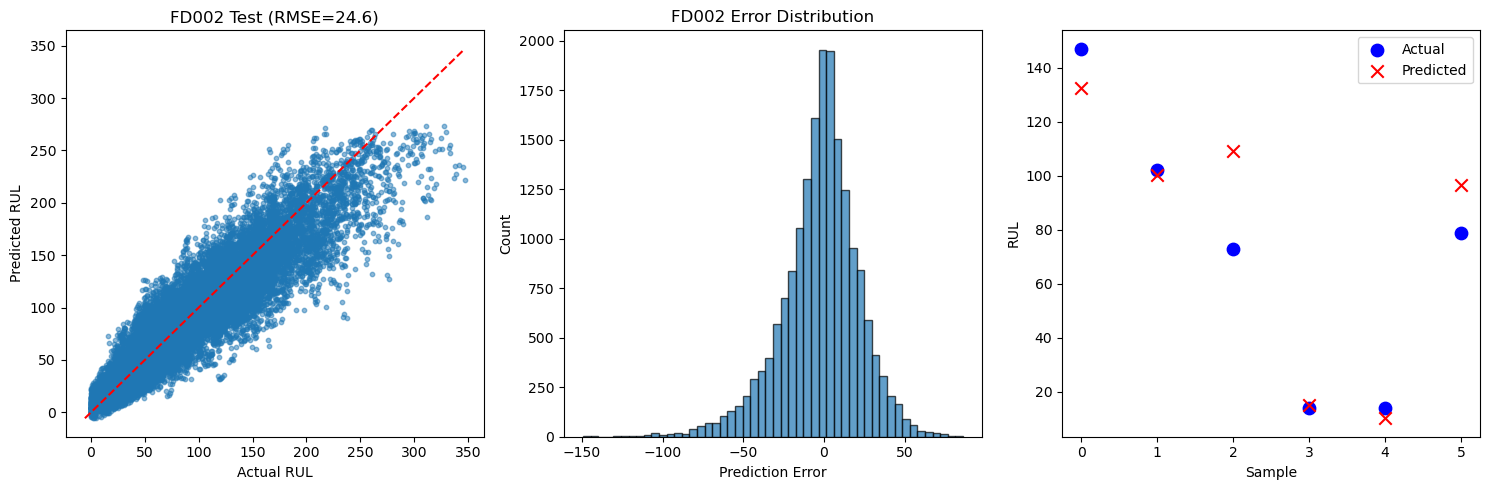

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

# Predicted vs Actual
plt.subplot(1,3,1)
plt.scatter(y2_test, y2_test_pred, alpha=0.5, s=10)
mn, mx = min(y2_test.min(), y2_test_pred.min()), max(y2_test.max(), y2_test_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"FD002 Test (RMSE={test_rmse_fd2:.1f})")

# Error distribution
errors_2 = y2_test_pred - y2_test
plt.subplot(1,3,2)
plt.hist(errors_2, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("FD002 Error Distribution")

# Sample predictions
plt.subplot(1,3,3)
for i in range(0, 30, 5):
    plt.scatter(i//5, y2_test[i], c='blue', s=80, label='Actual' if i==0 else "")
    plt.scatter(i//5, y2_test_pred[i], c='red', marker='x', s=80, label='Predicted' if i==0 else "")
plt.xlabel("Sample")
plt.ylabel("RUL")
plt.legend()

plt.tight_layout()
plt.savefig("fd002_evaluation_plots.png", dpi=300, bbox_inches="tight")
plt.show()


In [32]:
np.savez(
    'fd002_evaluation.npz',
    y_test=y2_test,
    y_test_pred=y2_test_pred,
    rmse=test_rmse_fd2,
    mae=test_mae_fd2
)

print("🎉 FD002 Milestone 3 COMPLETE!")
print("Saved: fd002_evaluation.npz, fd002_evaluation_plots.png")


🎉 FD002 Milestone 3 COMPLETE!
Saved: fd002_evaluation.npz, fd002_evaluation_plots.png


In [33]:
def classify_alert_fd2(rul):
    if rul < 10: return 'CRITICAL'
    elif rul < 30: return 'WARNING'
    elif rul < 125: return 'SAFE'
    return 'VERY_SAFE'

alert_levels_2 = [classify_alert_fd2(r) for r in y2_test_pred]

df_alerts_2 = pd.DataFrame({
    'actual_rul': y2_test,
    'predicted_rul': y2_test_pred,
    'alert_level': alert_levels_2
})

print("FD002 alert distribution:")
print(df_alerts_2['alert_level'].value_counts())

np.savez(
    'fd002_alerts.npz',
    actual_rul=y2_test,
    predicted_rul=y2_test_pred,
    alert_level=np.array(alert_levels_2, dtype=object)
)

print("🎉 FD002 Milestone 4 COMPLETE! Saved fd002_alerts.npz")


FD002 alert distribution:
alert_level
SAFE         10311
VERY_SAFE     4968
WARNING       2192
CRITICAL       913
Name: count, dtype: int64
🎉 FD002 Milestone 4 COMPLETE! Saved fd002_alerts.npz


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

col_names = ['unit', 'cycle'] + [f'setting{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]
train_df = pd.read_csv('CMAPSSData/train_FD003.txt', sep='\s+', header=None, names=col_names)
print(f"✅ FD003: {train_df.shape}")


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\MOUNIKA\AppData\Local\Temp\ipykernel_13952\3864817530.py:6: SyntaxWarning: invalid escape sequence '\s'
  train_df = pd.read_csv('CMAPSSData/train_FD003.txt', sep='\s+', header=None, names=col_names)


✅ FD003: (24720, 26)


In [35]:
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']
train_df = train_df.merge(max_cycles, on='unit')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
print("✅ FD003 RUL done")


✅ FD003 RUL done


In [36]:
sensor_cols = [f'sensor{i}' for i in range(1,22)]
scaler = MinMaxScaler()
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])
print("✅ FD003 normalized")


✅ FD003 normalized


In [37]:
def create_sequences(df, seq_length=30):
    X, y = [], []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].reset_index(drop=True)
        for i in range(seq_length, len(unit_df)):
            X.append(unit_df[sensor_cols].iloc[i-seq_length:i].values)
            y.append(unit_df['RUL'].iloc[i])
    return np.array(X), np.array(y)

X_fd003, y_fd003 = create_sequences(train_df)
print(f"✅ FD003 sequences: {X_fd003.shape}")


✅ FD003 sequences: (21720, 30, 21)


In [38]:
np.savez_compressed('fd003_sequences.npz', X=X_fd003, y=y_fd003)
np.save('fd003_scaler.npy', scaler)
print("✅ FD003 Milestone 1 COMPLETE")


✅ FD003 Milestone 1 COMPLETE


In [39]:
from sklearn.model_selection import train_test_split

X_temp, X_val, y_temp, y_val = train_test_split(X_fd003, y_fd003, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"✅ FD003 Splits: Train{X_train.shape}, Val{X_val.shape}, Test{X_test.shape}")


✅ FD003 Splits: Train(8688, 30, 21), Val(4344, 30, 21), Test(8688, 30, 21)


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    tf.keras.layers.Input(shape=(30, 21)),
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 30, 50)         │        10,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,551 (107.62 KB)

 Trainable params: 27,551 (107.62 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                   validation_data=(X_val, y_val), verbose=1)
print("✅ FD003 training complete")


Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 12879.3721 - val_loss: 8478.2275
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 7481.0342 - val_loss: 4035.1013
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 4038.6238 - val_loss: 3486.2295
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 3626.3145 - val_loss: 3454.2019
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 3321.8562 - val_loss: 2841.3208
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 3281.4336 - val_loss: 2657.5818
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 2970.3855 - val_loss: 2542.1936
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 2854.1091 - val_loss: 2374.7334
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 2809.2932 - val_loss: 2287.6179
Epoch 10/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 2668.1804 - val_loss: 2208.4124
Epoch 11/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 2626.

In [42]:
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(np.mean((y_val_pred.flatten() - y_val)**2))
print(f"✅ FD003 Val RMSE: {val_rmse:.2f}")


136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
✅ FD003 Val RMSE: 40.12


In [43]:
model.save_weights('fd003_gru_model.weights.h5')
np.savez_compressed('fd003_splits.npz', X_train=X_train, X_val=X_val, X_test=X_test,
                   y_train=y_train, y_val=y_val, y_test=y_test)
print("✅ FD003 Milestone 2 COMPLETE")


✅ FD003 Milestone 2 COMPLETE


In [44]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Test predictions
y_test_pred = model.predict(X_test).flatten()
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = np.mean(np.abs(y_test - y_test_pred))

print(f"✅ FD003 Test RMSE: {test_rmse:.2f}")
print(f"✅ FD003 Test MAE: {test_mae:.2f}")


272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
✅ FD003 Test RMSE: 41.33
✅ FD003 Test MAE: 27.06


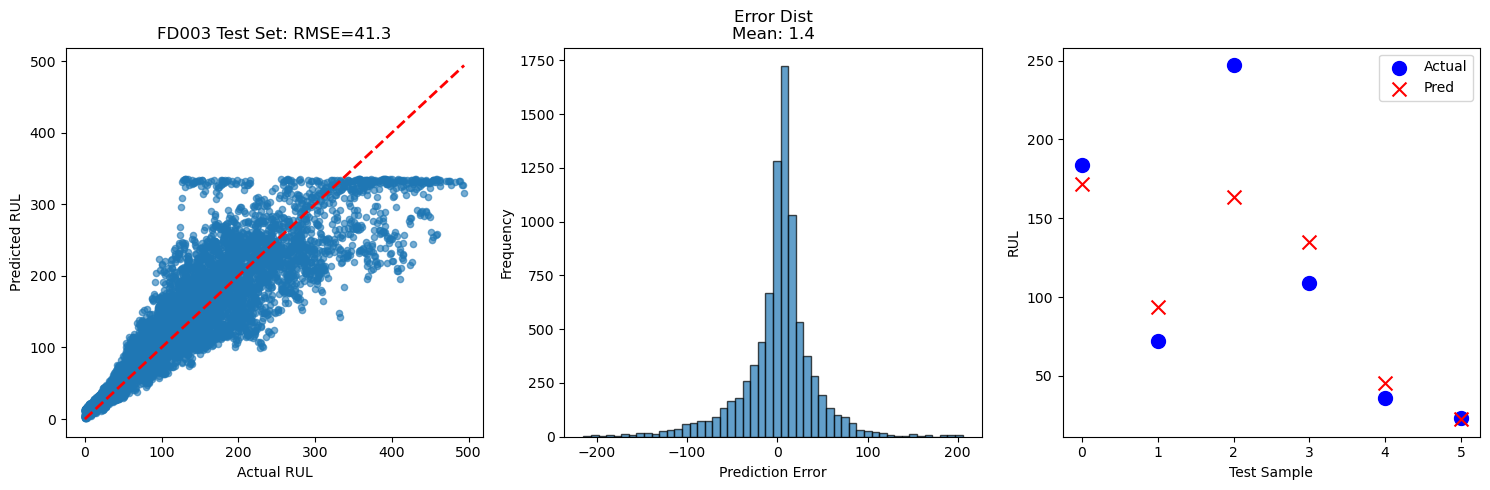

In [45]:
plt.figure(figsize=(15, 5))

# Predicted vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL'); plt.ylabel('Predicted RUL')
plt.title(f'FD003 Test Set: RMSE={test_rmse:.1f}')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test_pred - y_test
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error'); plt.ylabel('Frequency')
plt.title(f'Error Dist\nMean: {errors.mean():.1f}')

# Sample Predictions
plt.subplot(1, 3, 3)
for i in range(0, 30, 5):
    plt.scatter(i//5, y_test[i], c='blue', s=100, label='Actual' if i==0 else "")
    plt.scatter(i//5, y_test_pred[i], c='red', marker='x', s=100, label='Pred' if i==0 else "")
plt.xlabel('Test Sample'); plt.ylabel('RUL'); plt.legend()

plt.tight_layout()
plt.savefig('fd003_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [46]:
np.savez('fd003_evaluation.npz', y_test=y_test, y_test_pred=y_test_pred, 
         rmse=test_rmse, mae=test_mae)
print("✅ FD003 Milestone 3 COMPLETE!")


✅ FD003 Milestone 3 COMPLETE!


In [47]:
def classify_alert(rul):
    if rul < 10: return 'CRITICAL'
    elif rul < 30: return 'WARNING'
    elif rul < 125: return 'SAFE'
    return 'VERY_SAFE'

alerts = [classify_alert(p) for p in y_test_pred]
print("FD003 Alert Distribution:")
print(pd.Series(alerts).value_counts())

np.savez('fd003_alerts.npz', alerts_df=pd.Series(alerts))
print("✅ FD003 Milestone 4 COMPLETE!")


FD003 Alert Distribution:
SAFE         3933
VERY_SAFE    3769
WARNING       807
CRITICAL      179
Name: count, dtype: int64
✅ FD003 Milestone 4 COMPLETE!


In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

col_names = ['unit', 'cycle'] + [f'setting{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]
train_df = pd.read_csv('CMAPSSData/train_FD004.txt', sep='\s+', header=None, names=col_names)
print(f"✅ FD004: {train_df.shape}")  # Expect: ~65k rows (largest!)


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\MOUNIKA\AppData\Local\Temp\ipykernel_13952\368150834.py:6: SyntaxWarning: invalid escape sequence '\s'
  train_df = pd.read_csv('CMAPSSData/train_FD004.txt', sep='\s+', header=None, names=col_names)


✅ FD004: (61249, 26)


In [49]:
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']
train_df = train_df.merge(max_cycles, on='unit')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
print("✅ FD004 RUL done")


✅ FD004 RUL done


In [50]:
sensor_cols = [f'sensor{i}' for i in range(1,22)]
scaler = MinMaxScaler()
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])
print("✅ FD004 normalized")


✅ FD004 normalized


In [51]:
def create_sequences(df, seq_length=30):
    X, y = [], []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].reset_index(drop=True)
        for i in range(seq_length, len(unit_df)):
            X.append(unit_df[sensor_cols].iloc[i-seq_length:i].values)
            y.append(unit_df['RUL'].iloc[i])
    return np.array(X), np.array(y)

X_fd004, y_fd004 = create_sequences(train_df)
print(f"✅ FD004 sequences: {X_fd004.shape}")  # Expect: ~45k sequences


✅ FD004 sequences: (53779, 30, 21)


In [52]:
np.savez_compressed('fd004_sequences.npz', X=X_fd004, y=y_fd004)
np.save('fd004_scaler.npy', scaler)
print("✅ FD004 Milestone 1 COMPLETE")


✅ FD004 Milestone 1 COMPLETE


In [53]:
from sklearn.model_selection import train_test_split

X_temp, X_val, y_temp, y_val = train_test_split(X_fd004, y_fd004, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"✅ FD004 Splits: Train{X_train.shape}, Val{X_val.shape}, Test{X_test.shape}")


✅ FD004 Splits: Train(21511, 30, 21), Val(10756, 30, 21), Test(21512, 30, 21)


In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    tf.keras.layers.Input(shape=(30, 21)),
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 30, 50)         │        10,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,551 (107.62 KB)

 Trainable params: 27,551 (107.62 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                   validation_data=(X_val, y_val), verbose=1)
print("✅ FD004 training complete")


Epoch 1/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - loss: 8645.2119 - val_loss: 6744.2705
Epoch 2/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - loss: 7130.0122 - val_loss: 6743.3984
Epoch 3/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 7131.6924 - val_loss: 6740.6514
Epoch 4/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 7141.8555 - val_loss: 6746.5264
Epoch 5/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 7124.2666 - val_loss: 6749.9277
Epoch 6/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 7128.4629 - val_loss: 6734.9097
Epoch 7/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 6591.9487 - val_loss: 4894.8003
Epoch 8/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 4315.5078 - val_loss: 3418.9607
Epoch 9/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 3711.6250 - val_loss: 3339.8918
Epoch 10/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - loss: 3424.0769 - val_loss: 3035.8799
Epoch 11/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - lo

In [56]:
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(np.mean((y_val_pred.flatten() - y_val)**2))
print(f"✅ FD004 Val RMSE: {val_rmse:.2f}")


337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
✅ FD004 Val RMSE: 34.65


In [57]:
model.save_weights('fd004_gru_model.weights.h5')
np.savez_compressed('fd004_splits.npz', X_train=X_train, X_val=X_val, X_test=X_test,
                   y_train=y_train, y_val=y_val, y_test=y_test)
print("✅ FD004 Milestone 2 COMPLETE")


✅ FD004 Milestone 2 COMPLETE


In [58]:
from sklearn.metrics import mean_squared_error

y_test_pred = model.predict(X_test).flatten()
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = np.mean(np.abs(y_test - y_test_pred))

print(f"✅ FD004 Test RMSE: {test_rmse:.2f}")
print(f"✅ FD004 Test MAE: {test_mae:.2f}")


673/673 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
✅ FD004 Test RMSE: 34.21
✅ FD004 Test MAE: 24.75


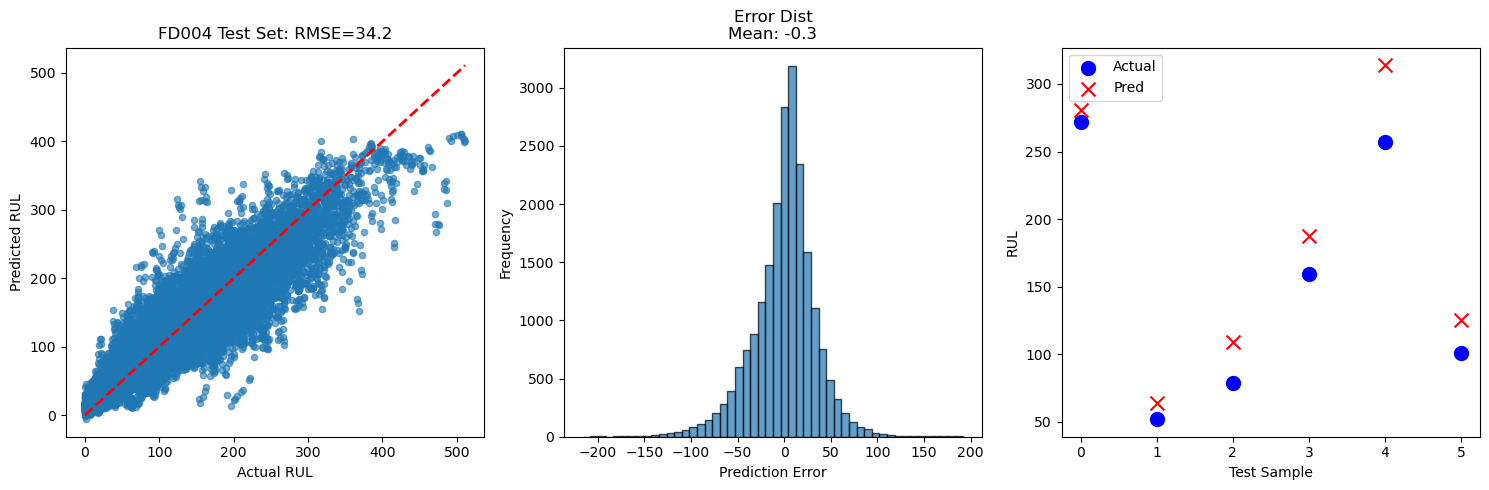

✅ FD004 plots saved!


In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1: Predicted vs Actual RUL
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL'); plt.ylabel('Predicted RUL')
plt.title(f'FD004 Test Set: RMSE={test_rmse:.1f}')

# Plot 2: Error Distribution
plt.subplot(1, 3, 2)
errors = y_test_pred - y_test
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error'); plt.ylabel('Frequency')
plt.title(f'Error Dist\nMean: {errors.mean():.1f}')

# Plot 3: Sample Predictions (first 30)
plt.subplot(1, 3, 3)
for i in range(0, 30, 5):
    plt.scatter(i//5, y_test[i], c='blue', s=100, label='Actual' if i==0 else "")
    plt.scatter(i//5, y_test_pred[i], c='red', marker='x', s=100, label='Pred' if i==0 else "")
plt.xlabel('Test Sample'); plt.ylabel('RUL')
plt.legend()

plt.tight_layout()
plt.savefig('fd004_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ FD004 plots saved!")


In [60]:
import pandas as pd

def classify_alert(rul):
    if rul < 10: return 'CRITICAL'
    elif rul < 30: return 'WARNING'
    elif rul < 125: return 'SAFE'
    return 'VERY_SAFE'

# Generate alerts for all test predictions
alert_levels = [classify_alert(r) for r in y_test_pred]

# Alert distribution
df_alerts = pd.DataFrame({
    'actual_rul': y_test,
    'predicted_rul': y_test_pred,
    'alert_level': alert_levels
})

print("FD004 Alert Distribution:")
print(df_alerts['alert_level'].value_counts().sort_index())
print(f"\nAverage actual RUL by alert:")
print(df_alerts.groupby('alert_level')['actual_rul'].mean().round(1))


FD004 Alert Distribution:
alert_level
CRITICAL      263
SAFE         9959
VERY_SAFE    9068
WARNING      2222
Name: count, dtype: int64

Average actual RUL by alert:
alert_level
CRITICAL       5.0
SAFE          81.0
VERY_SAFE    191.1
WARNING       16.7
Name: actual_rul, dtype: float64


In [61]:
# Save evaluation results
np.savez('fd004_evaluation.npz', 
         y_test=y_test, 
         y_test_pred=y_test_pred, 
         rmse=test_rmse, 
         mae=test_mae)

# Save alerts
np.savez('fd004_alerts.npz', 
         alerts=np.array(alert_levels, dtype=object),
         thresholds={'critical':10, 'warning':30, 'safe':125})

print("🎉 FD004 ALL MILESTONES COMPLETE!")
print("✅ Files saved:")
print("   fd004_evaluation.npz")
print("   fd004_alerts.npz") 
print("   fd004_evaluation_plots.png")
print("\n📁 ALL FD001-FD004 FILES READY FOR MASTER DASHBOARD!")


🎉 FD004 ALL MILESTONES COMPLETE!
✅ Files saved:
   fd004_evaluation.npz
   fd004_alerts.npz
   fd004_evaluation_plots.png

📁 ALL FD001-FD004 FILES READY FOR MASTER DASHBOARD!
